In [1]:
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" 
# from models import DailyStats
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
import pandas as pd
import numpy as np
import datetime


from sklearn.pipeline         import Pipeline
from sklearn.compose         import ColumnTransformer
from sklearn.impute          import SimpleImputer
from sklearn.preprocessing   import StandardScaler, OneHotEncoder, OrdinalEncoder
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, SimpleRNN, Dense, Dropout, LSTM, GRU, BatchNormalization
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.losses import Huber

from feature_engineering import _prepare_training_frame, drop_outliers
from pipeline import _build_pipeline




load_dotenv()  # reads .env in working directory
db_url = os.getenv("DATABASE_URL")
db_url = "postgres://u76gs2mfn3l2um:p1577d0e7a90ab74ce0a8dcbd5dab809f4240ab92836929df08e328b6c82c5a13@c2hbg00ac72j9d.cluster-czrs8kj4isg7.us-east-1.rds.amazonaws.com:5432/d35v2smh8r48et"
print(db_url)
# Heroku uses postgres:// but SQLAlchemy expects postgresql://
if db_url.startswith("postgres://"):
    db_url = db_url.replace("postgres://", "postgresql://", 1)

engine = create_engine(db_url)
best = 100000000

postgres://u76gs2mfn3l2um:p1577d0e7a90ab74ce0a8dcbd5dab809f4240ab92836929df08e328b6c82c5a13@c2hbg00ac72j9d.cluster-czrs8kj4isg7.us-east-1.rds.amazonaws.com:5432/d35v2smh8r48et


In [2]:
# # now read and print
# df_daily = pd.read_sql("SELECT * FROM daily_stats;", con=engine)

# # now read and print
# df_daily = pd.read_sql("SELECT * FROM daily_stats;", con=engine)
# df_daily['raw_tags'] = df_daily['tags'].apply(lambda x: x if isinstance(x, list) else [])

# # — prep the frame and feature list
# df_clean, features, hist_cols = _prepare_training_frame(df_daily)
# df_clean = df_clean.sort_values(['stream_name', 'stream_date'])
# df_clean = drop_outliers(df_clean, cols=['total_subscriptions', 'avg_concurrent_viewers', 'net_follower_change'] ,method='iqr', factor=25.0)

# full_pipe, model_type = _build_pipeline(df_clean[features])
# pre: pd.DataFrame  = full_pipe.named_steps['pre']

# # X_all = pre.fit_transform(df_clean[features])

# # # Optionally grab the transformed feature names
# # try:
# #     feature_names = pre.get_feature_names_out()
# # except:
# #     feature_names = [f"f{i}" for i in range(X_all.shape[1])]

# # # — build sliding‐window sequences of length `timesteps`
# # timesteps = 10
# # seqs, targets = [], []

# # # we’ll use total_subscriptions as the example target
# # y_all = df_clean['total_subscriptions'].values

# # 0) sort and reset index so positions == labels
# df_sorted = df_clean.sort_values(['stream_name','stream_date']).reset_index(drop=True)

# df_sorted.tail()

In [3]:

# # 1) per-streamer split point (80% of each streamer's history)
# split_points = {name: int(0.8*len(g)) for name, g in df_sorted.groupby('stream_name', sort=False)}

# # 2) train/test masks at the ROW level
# row_is_train = np.zeros(len(df_sorted), dtype=bool)
# for name, g in df_sorted.groupby('stream_name', sort=False):
#     ntr = split_points[name]
#     row_is_train[g.index[:ntr]] = True

# # 3) fit preprocessor on TRAIN ONLY, then transform all
# pre = full_pipe.named_steps['pre']
# pre.fit(df_sorted.loc[row_is_train, features])
# X_all = pre.transform(df_sorted[features]).astype(np.float32)  # dense, no leak
# y_all = df_sorted['total_subscriptions'].values.astype(np.float32)

# grouped_idx = df_clean.groupby('stream_name').indices



# # for streamer, idx in grouped_idx.items():
# #     X_stream = X_all[idx]       # shape (n_stream_rows, n_pre_features)
# #     y_stream = y_all[idx]       # shape (n_stream_rows,)

# #     # for each window of length=timesteps, predict the next step
# #     for i in range(len(X_stream) - timesteps):
# #         seqs.append(X_stream[i : i + timesteps])
# #         targets.append(y_stream[i + timesteps])

# # # stack into arrays
# # X = np.stack(seqs)              # (n_samples, timesteps, n_pre_features)
# # y = np.array(targets)           # (n_samples,)

# # # ─────────────────────────────────────────────────────────────────────────────
# # # 6) Split into train/test (80/20 by time order)
# # # ─────────────────────────────────────────────────────────────────────────────
# # n_train = int(0.8 * len(X))
# # X_train, X_test = X[:n_train], X[n_train:]
# # y_train, y_test = y[:n_train], y[n_train:]

# timesteps = 10
# X_train, y_train, X_test, y_test = [], [], [], []

# for name, g in df_sorted.groupby('stream_name', sort=False):
#     idx = g.index.to_numpy()                 # positional after reset_index
#     Xs  = X_all[idx]
#     ys  = y_all[idx]
#     ntr = split_points[name]

#     # training windows end before the split
#     for i in range(0, ntr - timesteps):
#         X_train.append(Xs[i:i+timesteps])
#         y_train.append(ys[i+timesteps])

#     # test windows start at/after the split
#     for i in range(ntr - timesteps, len(Xs) - timesteps):
#         if i < 0: 
#             continue
#         X_test.append(Xs[i:i+timesteps])
#         y_test.append(ys[i+timesteps])

# X_train, y_train = np.stack(X_train), np.array(y_train)
# X_test,  y_test  = np.stack(X_test),  np.array(y_test)



In [52]:
# — read & prep
df_daily = pd.read_sql("SELECT * FROM daily_stats;", con=engine)
df_daily['raw_tags'] = df_daily['tags'].apply(lambda x: x if isinstance(x, list) else [])

df_clean, features, hist_cols = _prepare_training_frame(df_daily)

# match the cleaning in your "full pipeline" example
# df_clean = df_clean.dropna()
df_clean = drop_outliers(
    df_clean,
    cols=['total_subscriptions', 'avg_concurrent_viewers', 'net_follower_change'],
    method='iqr',
    factor=8
)

# stable ordering (not required for the split, but nice to keep)
df_clean = df_clean.sort_values(['stream_name', 'stream_date']).reset_index(drop=True)

# build pipeline and grab ONLY the preprocessor
full_pipe, model_type = _build_pipeline(df_clean[features])
pre: pd.DataFrame = full_pipe.named_steps['pre']
# ─────────────────────────────────────────────────────────────────────────────
# 1) Preprocess (fit on train only, per-stream 80% split by time)
# ─────────────────────────────────────────────────────────────────────────────
df_sorted = df_clean.sort_values(['stream_name','stream_date']).reset_index(drop=True)

# per-stream split point (80%)
split_points = {name: int(0.8*len(g)) for name, g in df_sorted.groupby('stream_name', sort=False)}

row_is_train = np.zeros(len(df_sorted), dtype=bool)
for name, g in df_sorted.groupby('stream_name', sort=False):
    ntr = split_points[name]
    row_is_train[g.index[:ntr]] = True

# fit preprocessor on TRAIN rows only
pre = full_pipe.named_steps['pre']
pre.fit(df_sorted.loc[row_is_train, features])

# transform ALL rows with train-fitted preprocessor
def _to_dense(X):
    return X.toarray() if hasattr(X, "toarray") else np.asarray(X)

# —— Guarantee a test set for sequence windows ——
def _make_split_points_with_test(df_sorted, timesteps, start_ratio=0.80, min_ratio=0.60, step=0.05):
    """
    Returns split_points[name] = ntr (row count for train per stream) such that
    at least one test window can be formed across the dataset, if feasible.
    """
    # Try progressively smaller train ratios until at least one test window exists
    ratio = start_ratio
    while ratio >= min_ratio:
        split_points = {}
        total_test_windows = 0

        for name, g in df_sorted.groupby('stream_name', sort=False):
            n = len(g)

            if n < timesteps:
                # Not enough rows for any window; all train, no test here
                split_points[name] = n
                continue

            # Base split from ratio
            ntr = int(ratio * n)

            # Ensure at least ONE test window: need ntr <= (n - timesteps)
            ntr = min(ntr, n - timesteps)

            # If the stream is long enough to have at least one train window too,
            # ensure ntr >= timesteps
            if n >= 2 * timesteps:
                ntr = max(ntr, timesteps)

            # Clamp
            ntr = max(0, min(n, ntr))
            split_points[name] = ntr

            # Count how many test windows this split would yield
            last_start_test = n - timesteps
            if last_start_test >= ntr:
                total_test_windows += (last_start_test - ntr + 1)

        if total_test_windows > 0:
            return split_points  # success with this ratio

        ratio -= step

    # Last resort: force a split that guarantees test windows if n >= timesteps
    # (may sacrifice train windows on very short streams)
    split_points = {}
    for name, g in df_sorted.groupby('stream_name', sort=False):
        n = len(g)
        split_points[name] = max(0, n - timesteps)  # ensures last_start_test >= ntr
    return split_points


timesteps = 1

# —— 1) Build robust split points (guarantee at least one test window overall) ——
split_points = _make_split_points_with_test(df_sorted, timesteps=timesteps)

# Your existing transforms
X_all = _to_dense(pre.transform(df_sorted[features])).astype(np.float32)
y_all = df_sorted['total_subscriptions'].values.astype(np.float32)
# y_all = df_sorted['avg_concurrent_viewers'].values.astype(np.float32)

# from sklearn.preprocessing import StandardScaler

# scaler_y = StandardScaler()
# y_all = scaler_y.fit_transform(y_all.reshape(-1, 1)).astype(np.float32)

# —— 2) Sequence builder (unchanged) ——


X_train_seq, y_train_seq = [], []
X_test_seq,  y_test_seq  = [], []

for name, g in df_sorted.groupby('stream_name', sort=False):
    idx = g.index.to_numpy()
    n   = len(idx)
    ntr = split_points[name]

    # TRAIN windows: start in [0, ntr - timesteps]
    last_start_train = ntr - timesteps
    if last_start_train >= 0:
        for start in range(0, last_start_train + 1):
            sl = idx[start:start+timesteps]
            X_train_seq.append(X_all[sl, :])
            y_train_seq.append(y_all[sl[-1]])

    # TEST windows: start in [ntr, n - timesteps]
    last_start_test = n - timesteps
    if last_start_test >= ntr:
        for start in range(ntr, last_start_test + 1):
            sl = idx[start:start+timesteps]
            X_test_seq.append(X_all[sl, :])
            y_test_seq.append(y_all[sl[-1]])

# stack to arrays
X_train = np.stack(X_train_seq) if X_train_seq else np.empty((0, timesteps, X_all.shape[1]), dtype=np.float32)
y_train = np.asarray(y_train_seq, dtype=np.float32)

X_test  = np.stack(X_test_seq)  if X_test_seq  else np.empty((0, timesteps, X_all.shape[1]), dtype=np.float32)
y_test  = np.asarray(y_test_seq, dtype=np.float32)


print('X_train shape', X_train.shape)
print('X_test shape', X_test.shape)

# (optional) assert we actually have a test set now
if len(X_test) == 0:
    raise RuntimeError("No test windows could be formed. Consider lowering timesteps or widening the test split.")


/Users/christopherclark/Library/Mobile Documents/com~apple~CloudDocs/_Chris_Docs/Coding/darksharkml/feature_engineering.py:153: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["stream_start_time"] = pd.to_datetime(
/Users/christopherclark/Library/Mobile Documents/com~apple~CloudDocs/_Chris_Docs/Coding/darksharkml/feature_engineering.py:168: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('stream_name', group_keys=False)


X_train shape (339, 1, 398)
X_test shape (100, 1, 398)


In [53]:
# import pandas as pd
# import numpy as np
# # Assume these helper functions and variables are defined elsewhere in your code:
# # from your_module import _prepare_training_frame, _build_pipeline, drop_outliers
# # engine = create_engine(...)

# # --- Configuration ---
# STREAM_NAME_TO_PROCESS = 'thelegendyagami'
# TIMESTEPS = 4  # How many past days to use for a prediction
# TRAIN_RATIO = 0.8 # The percentage of data to use for training

# # --- 1. Read and Prepare Data ---
# # Load the initial dataset
# df_daily = pd.read_sql("SELECT * FROM daily_stats;", con=engine)
# df_daily['raw_tags'] = df_daily['tags'].apply(lambda x: x if isinstance(x, list) else [])

# # Prepare the training frame using your existing function
# df_clean, features, hist_cols = _prepare_training_frame(df_daily)

# # --- 2. Filter and Clean for a Single Stream ---
# # Filter for only the specified stream
# df_single_stream = df_clean[df_clean['stream_name'] == STREAM_NAME_TO_PROCESS].copy()

# # Drop NA values and outliers
# df_single_stream = df_single_stream.dropna()
# # df_single_stream = drop_outliers(
# #     df_single_stream,
# #     cols=['total_subscriptions', 'avg_concurrent_viewers', 'net_follower_change'],
# #     method='iqr',
# #     factor=2.5
# # )

# # Sort by date to ensure correct time-series order
# df_single_stream = df_single_stream.sort_values('stream_date').reset_index(drop=True)

# print(f"Processing {len(df_single_stream)} data points for stream '{STREAM_NAME_TO_PROCESS}'.")

# # --- 3. Preprocess the Data ---
# # Build the pipeline and get the preprocessor step
# full_pipe, model_type = _build_pipeline(df_single_stream[features])
# pre = full_pipe.named_steps['pre']

# # Determine the split point for training and testing
# n = len(df_single_stream)
# # Ensure the test set is large enough for at least one sequence
# # The training set ends at `ntr`, the test set starts right after.
# # The last possible start for a test sequence is `n - TIMESTEPS`.
# # So, the training data must end before or at that point.
# last_possible_train_index = n - TIMESTEPS
# ntr = int(n * TRAIN_RATIO)
# ntr = min(ntr, last_possible_train_index) # Adjust if the ratio split is too large

# # Check if there's enough data to create training and testing sets
# if ntr < TIMESTEPS:
#     raise ValueError(
#         f"Not enough data for stream '{STREAM_NAME_TO_PROCESS}' to form even one training window. "
#         f"Need at least {2 * TIMESTEPS} data points, but found {n}."
#     )

# # Fit the preprocessor ONLY on the training data
# train_df = df_single_stream.iloc[:ntr]
# pre.fit(train_df[features])

# # Transform the entire dataset using the fitted preprocessor
# X_all = pre.transform(df_single_stream[features])
# y_all = df_single_stream['total_subscriptions'].values.astype(np.float32)


# # --- 4. Build Time-Series Sequences ---
# X_train_seq, y_train_seq = [], []
# X_test_seq,  y_test_seq  = [], []

# # Create training sequences
# # A sequence starts at `i` and ends at `i + TIMESTEPS - 1`.
# # The last possible start for a training sequence is `ntr - TIMESTEPS`.
# for i in range(ntr - TIMESTEPS + 1):
#     X_train_seq.append(X_all[i : i + TIMESTEPS])
#     y_train_seq.append(y_all[i + TIMESTEPS - 1]) # Target is the last value in the window

# # Create testing sequences
# # Test sequences start after the training data, from `ntr`.
# # The last possible start for a test sequence is `n - TIMESTEPS`.
# for i in range(ntr, n - TIMESTEPS + 1):
#     X_test_seq.append(X_all[i : i + TIMESTEPS])
#     y_test_seq.append(y_all[i + TIMESTEPS - 1])

# # Convert lists of sequences to NumPy arrays
# X_train = np.array(X_train_seq)
# y_train = np.array(y_train_seq)
# X_test = np.array(X_test_seq)
# y_test = np.array(y_test_seq)

# # --- 5. Final Output ---
# print(f"Training data shape: {X_train.shape}")
# print(f"Training labels shape: {y_train.shape}")
# print(f"Testing data shape: {X_test.shape}")
# print(f"Testing labels shape: {y_test.shape}")

# if len(X_test) == 0:
#     print("Warning: No test windows could be formed with the current settings.")



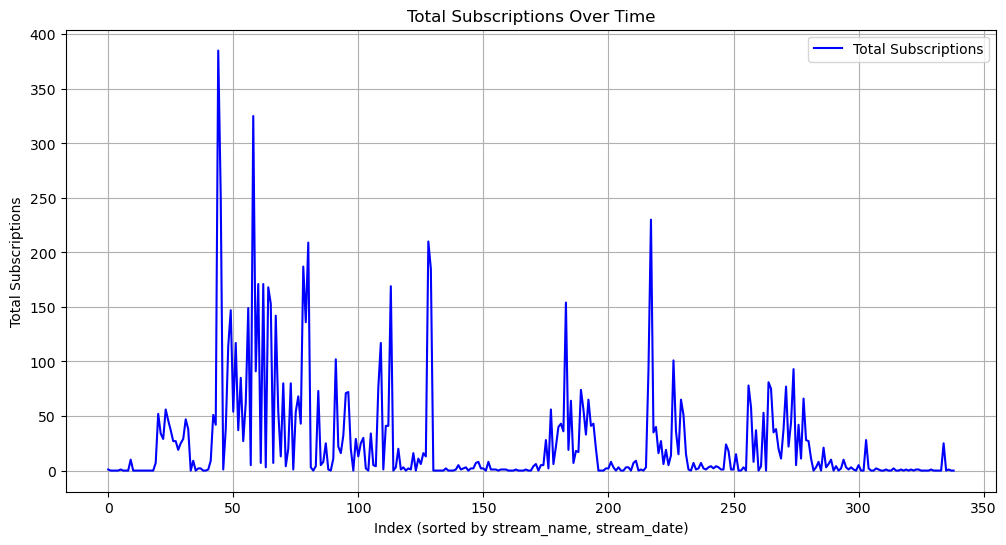

In [54]:
# Plot y_all to visualize the raw target variable distribution

# y_scaler = StandardScaler()
# y_train = y_scaler.fit_transform(np.asarray(y_train).reshape(-1, 1)).ravel()

plt.figure(figsize=(12, 6))
plt.plot(y_train, label="Total Subscriptions", color="blue")
plt.title("Total Subscriptions Over Time")
plt.xlabel("Index (sorted by stream_name, stream_date)")
plt.ylabel("Total Subscriptions")
plt.legend()
plt.grid()
plt.show()

In [55]:


# ─────────────────────────────────────────────────────────────────────────────
# 7) Hyperparameters for your RNN
# ─────────────────────────────────────────────────────────────────────────────
timesteps     = X_train.shape[1]   # e.g. 10
n_features    = X_train.shape[2]
rnn_units     = 16
dense_units   = 16
learning_rate = 1e-2
drop_rate     = 0.5


# ——— Build model with dropout & recurrent_dropout ———
model = Sequential([
    # Swap in LSTM or GRU if you need longer-term memory
    LSTM(
        units=rnn_units,
        return_sequences=True,
        input_shape=(timesteps, n_features),
        activation='tanh',
        dropout=drop_rate,          
        recurrent_dropout=drop_rate 
    ),
    Dropout(drop_rate),             # extra dropout on the RNN output

    LSTM(
        units=rnn_units,
        activation='tanh',
        dropout=drop_rate,
        recurrent_dropout=drop_rate
    ),
    Dropout(drop_rate),


    Dense(
        dense_units,
        activation='relu'
    ),
    Dropout(drop_rate),


    Dense(1, activation='linear')   # final regression output
])

model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    # loss=Huber(delta=1.0),
    loss='mse',       # mean squared error
    metrics=['mae']   # mean absolute error
)

# model.summary()

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# 2) Instantiate the TensorBoard callback
tensorboard_cb = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,       # record layer activations & weight histograms each epoch
    write_graph=True,       # visualize the graph
    write_images=False      # set True to log model weights as images
)
# ——— Callbacks ———
callbacks = [
    tensorboard_cb,
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]


/opt/anaconda3/envs/tf-mac/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_split=0.3,   # or (X_val, y_val)
    epochs=200,
    batch_size=8,
    callbacks=callbacks
)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Plot loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],  label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot MAE
plt.figure(figsize=(8,4))
plt.plot(history.history['mae'],  label='train MAE')
plt.plot(history.history['val_mae'], label='val MAE')
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()

# ——— 2) Evaluate on your held-out test set ———
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {test_loss:.3f}   Test MAE: {test_mae:.3f}")

# ——— 3) Compare predictions vs ground truth ———
y_pred = model.predict(X_test).ravel()

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'k--', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual on Test Set")
plt.show()

# ——— 4) Optional: print extra metrics ———
# print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Test MAE: ", mean_absolute_error(y_test, y_pred))
print(f"R² = {r2_score(y_test, y_pred):.2f}")


In [ ]:
# df_daily = pd.read_sql("SELECT * FROM daily_stats;", con=engine)
# # df_clean = df_daily.dropna()
# # df_daily.drop(columns=['tags'])
# df_daily.tail()
# target = "total_subscriptions"
# X = df_daily.drop(columns=[target, 'tags'])
# y = df_daily[target].drop(columns=['tags'])

# # 1) Split first
# X_train_raw, X_test_raw, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42  # add stratify=y for classification
# )

# # 2) Fit encoder on train only
# cat_cols = X_train_raw.select_dtypes(include=["object", "category"]).columns
# num_cols = X_train_raw.select_dtypes(exclude=["object", "category"]).columns

# pre = ColumnTransformer([
#     ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
#     ("num", "passthrough", num_cols),
# ])

# X_train = pre.fit_transform(X_train_raw)
# X_test  = pre.transform(X_test_raw)

# # Optional: names for debugging
# feature_names = pre.get_feature_names_out()

In [119]:
def build_simple_1d_cnn_regression(input_length, num_features):
    model = Sequential([
        # First convolutional block
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(input_length, num_features), padding='same'),
        # MaxPooling1D(pool_size=2),
        # Dropout(0.1),

        # Second convolutional block
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        # MaxPooling1D(pool_size=2),
        # Dropout(0.1),

        Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
        # # MaxPooling1D(pool_size=2),
        # Dropout(0.1),

        Conv1D(filters=256, kernel_size=10, activation='relu', padding='same'),
        # # MaxPooling1D(pool_size=2),
        # Dropout(0.1),

        # Flatten and dense layers
        Flatten(),
        Dense(32, activation='relu'),
        Dropout(0.3),

        # Output layer — single numeric prediction
        Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        # loss='mse',      # Mean Squared Error for regression
        loss=tf.keras.losses.Huber(delta=1.0),
        metrics=['mae']  # Mean Absolute Error for monitoring
    )
    return model

# Example usage
input_length = timesteps    # Number of timesteps per sample
num_features = n_features     # Number of features per timestep
model = build_simple_1d_cnn_regression(input_length, num_features)
# model.summary()

In [120]:
# y_scaler = StandardScaler()
# y_train = y_scaler.fit_transform(np.asarray(y_train).reshape(-1, 1)).ravel()

print('X_train Shape:', X_train.shape)
history = model.fit(
    X_train, y_train,
    validation_split=0.3,   # or (X_val, y_val)
    epochs=200,
    batch_size=1,
    callbacks=callbacks
)

print()
es = next((cb for cb in callbacks if isinstance(cb, tf.keras.callbacks.EarlyStopping)), None)
if es:
    print(f"EarlyStopping best {es.monitor}: {es.best:.6f}")

if es.best < best:
    best = es.best
print("All time best so far:", best)

X_train Shape: (339, 1, 398)
Epoch 1/200
237/237 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 29.2634 - mae: 29.7093 - val_loss: 10.7123 - val_mae: 11.1455 - learning_rate: 0.0010
Epoch 2/200
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 23.9225 - mae: 24.3942 - val_loss: 8.0394 - val_mae: 8.4870 - learning_rate: 0.0010
Epoch 3/200
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 22.6038 - mae: 23.0708 - val_loss: 8.4131 - val_mae: 8.8578 - learning_rate: 0.0010
Epoch 4/200
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 22.8289 - mae: 23.2920 - val_loss: 8.0237 - val_mae: 8.5189 - learning_rate: 0.0010
Epoch 5/200
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 21.7328 - mae: 22.2110 - val_loss: 6.5441 - val_mae: 7.0101 - learning_rate: 0.0010
Epoch 6/200
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 19.9344 - mae: 20.3937 - val_loss: 6.0237 - val_mae: 6.4822 - learning_rate: 0.0010
Epoch 7/200
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 21.6501 - mae: 22.1136 - val_lo

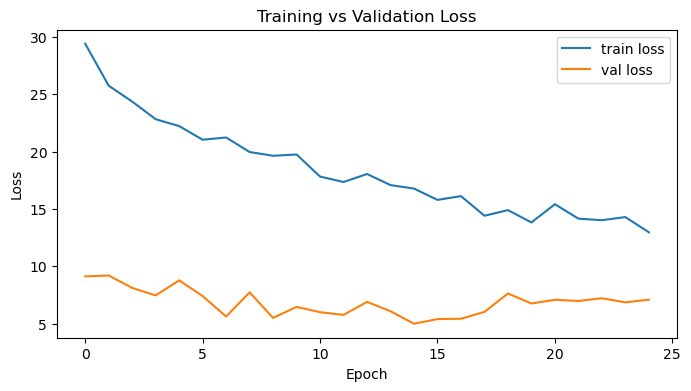

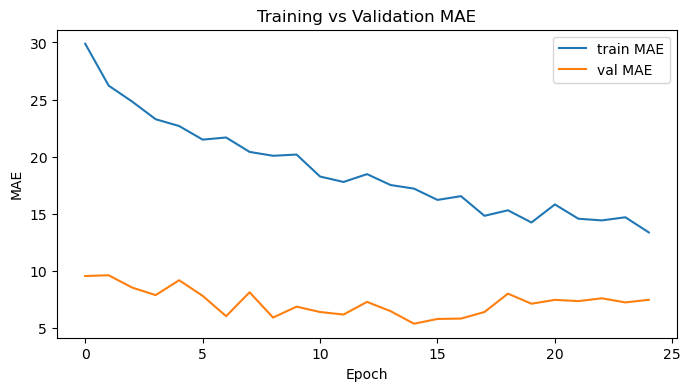

Test MSE: 16.217   Test MAE: 16.646
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


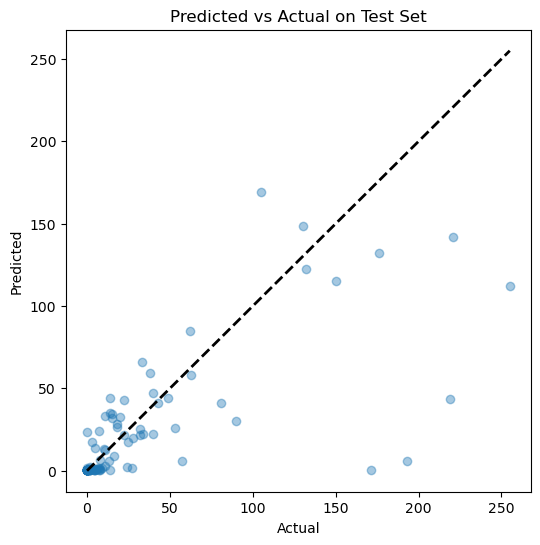

Test MAE:  16.646217346191406
R² = 0.49


In [110]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Plot loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],  label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot MAE
plt.figure(figsize=(8,4))
plt.plot(history.history['mae'],  label='train MAE')
plt.plot(history.history['val_mae'], label='val MAE')
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()

# ——— 2) Evaluate on your held-out test set ———
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {test_loss:.3f}   Test MAE: {test_mae:.3f}")

# ——— 3) Compare predictions vs ground truth ———
y_pred = model.predict(X_test).ravel()

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'k--', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual on Test Set")
plt.show()

# ——— 4) Optional: print extra metrics ———
# print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Test MAE: ", mean_absolute_error(y_test, y_pred))
print(f"R² = {r2_score(y_test, y_pred):.2f}")


In [ ]:
# import numpy as np
# import pandas as pd

# def clean_for_keras_cnn(X, y, timesteps=None, n_features=None,
#                         datetime_cols=None, drop_if_present=('tags',)):
#     """
#     Accepts DataFrame or ndarray.
#     - If DataFrame: drops 'tags' (if present), coerces objects, converts datetimes.
#     - If ndarray: coerces to numeric.
#     - Reshapes 2D -> 3D if timesteps and n_features are provided.
#       (If X is already 3D, reshape is skipped.)
#     """
#     # ---- X to numeric ----
#     if isinstance(X, np.ndarray):
#         X_np = X
#         if X_np.dtype == object:
#             # coerce object array via pandas
#             X_np = pd.DataFrame(X_np).apply(pd.to_numeric, errors='coerce').fillna(0.0).to_numpy(dtype='float32')
#         else:
#             X_np = X_np.astype('float32', copy=False)
#     else:
#         X_df = X.copy()
#         # optional drops (e.g., raw list column)
#         for c in drop_if_present:
#             if c in X_df.columns:
#                 X_df = X_df.drop(columns=[c])
#         # datetimes -> seconds
#         for c in (datetime_cols or []):
#             if c in X_df.columns:
#                 X_df[c] = pd.to_datetime(X_df[c], errors='coerce').view('int64') / 1e9
#         # objects -> numeric; bool -> int
#         for c in X_df.select_dtypes(include=['object']).columns:
#             X_df[c] = pd.to_numeric(X_df[c], errors='coerce')
#         for c in X_df.select_dtypes(include=['bool']).columns:
#             X_df[c] = X_df[c].astype('int8')
#         X_np = X_df.fillna(0.0).to_numpy(dtype='float32')

#     # ---- reshape for Conv1D ----
#     if X_np.ndim == 2 and (timesteps is not None and n_features is not None):
#         expected = timesteps * n_features
#         if X_np.shape[1] != expected:
#             raise ValueError(
#                 f"Feature width {X_np.shape[1]} != timesteps*n_features ({expected}). "
#                 "Adjust timesteps/n_features or how you build windows."
#             )
#         X_np = X_np.reshape(-1, timesteps, n_features)
#     elif X_np.ndim == 3:
#         pass
#     else:
#         raise ValueError(f"X must be 2D or 3D; got shape {X_np.shape}")

#     # ---- y to numeric vector ----
#     if isinstance(y, (pd.Series, pd.DataFrame)):
#         y_np = pd.to_numeric(pd.Series(y).squeeze(), errors='coerce').fillna(0.0).to_numpy(dtype='float32')
#     else:
#         y_np = np.asarray(y, dtype='float32')

#     return X_np, y_np


# # Example usage

# # timesteps  = X_train_np.shape[1]   # 589
# # n_features = X_train_np.shape[2]   # 1



# X_train_np, y_train_np = clean_for_keras_cnn(X_train, y_train, timesteps=timesteps, n_features=n_features)
# X_test_np,  y_test_np  = clean_for_keras_cnn(X_test,  y_test,  timesteps=timesteps, n_features=n_features)

# def check_and_filter_finite(X, y):
#     X = np.asarray(X); y = np.asarray(y)
#     mask = np.isfinite(X).all(axis=(1,2)) & np.isfinite(y)
#     if mask.sum() < len(y):
#         print(f"Dropping {(~mask).sum()} samples with non-finite values")
#     return X[mask], y[mask]

# X_train_np, y_train_np = check_and_filter_finite(X_train_np, y_train_np)
# X_test_np,  y_test_np  = check_and_filter_finite(X_test_np,  y_test_np)

# timesteps, n_features = 589, 1
# X_train_np = np.asarray(X_train_np, dtype='float32').reshape(-1, timesteps, n_features)
# X_test_np  = np.asarray(X_train_np,  dtype='float32').reshape(-1, timesteps, n_features)
# print('Shape X_train', X_train_np.shape)

# X_train_np = pre.fit_transform(X_train_np)
# X_test_np  = pre.transform(X_test_np)


# callbacks = [
#     tensorboard_cb,
#     EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
# ]
# history = model.fit(
#     X_train_np, y_train_np, 
#     validation_split=0.3, 
#     epochs=200, 
#     batch_size=8, 
#     callbacks=callbacks)



In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

In [ ]:
y_train_t = np.log1p(y_train)
y_test_t  = np.log1p(y_test)

from tensorflow.keras import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    GRU(32),
    Dropout(0.1),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])
model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train_t,
          validation_data=(X_test, y_test_t),
          epochs=300, batch_size=64,
          callbacks=[
              EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
              ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
          ])

# MAE on original scale
pred = np.expm1(model.predict(X_test).ravel())
mae  = np.mean(np.abs(pred - y_test))
print("Test MAE:", mae)

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, ReLU, Dropout
from tensorflow.keras.layers import GlobalAveragePooling1D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

timesteps, n_features = X_train.shape[1], X_train.shape[2]
y_train_t = np.log1p(y_train)
y_test_t  = np.log1p(y_test)

model = Sequential([
    Conv1D(64, kernel_size=3, padding="causal", activation=None, input_shape=(timesteps, n_features)),
    BatchNormalization(), ReLU(), Dropout(0.2),

    Conv1D(64, kernel_size=3, padding="causal", activation=None),
    BatchNormalization(), ReLU(), Dropout(0.2),

    Conv1D(32, kernel_size=3, padding="causal", activation=None),
    BatchNormalization(), ReLU(),

    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1)  # linear regression head
])

model.compile(optimizer=Adam(1e-3), loss="mae", metrics=["mae"])
history = model.fit(X_train, y_train_t,  # or use log1p target if skewed
          validation_data=(X_test, y_test_t),
          epochs=200, batch_size=128,
          callbacks=[EarlyStopping(patience=15, restore_best_weights=True),
                     ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-5)])

# MAE on original scale
pred = np.expm1(model.predict(X_test).ravel())
mae  = np.mean(np.abs(pred - y_test_t))
print("Test MAE:", mae)